In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [4]:
# Load Dataset
df = pd.read_csv('loan-approval.csv')

In [6]:
# Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


In [8]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [10]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


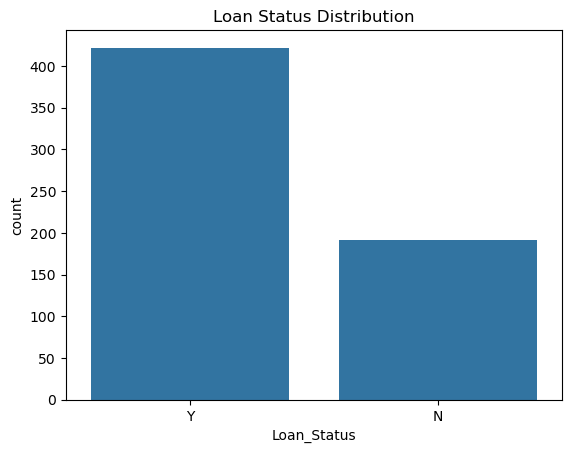

In [12]:
# Visualizing target variable distribution
sns.countplot(x='Loan_Status', data=df)
plt.title("Loan Status Distribution")
plt.show()

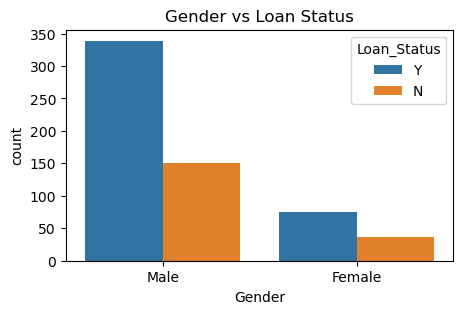

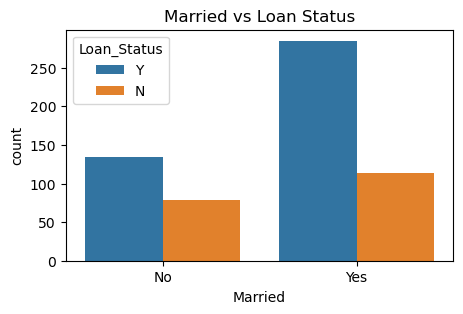

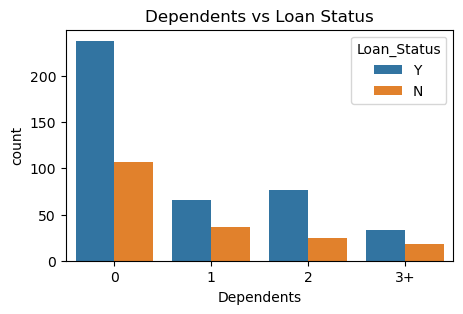

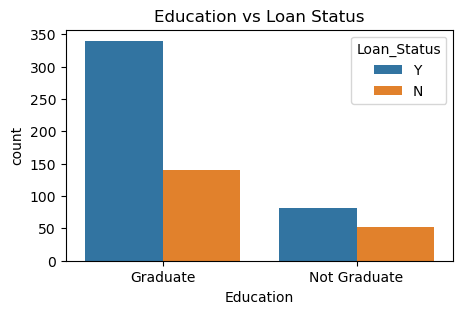

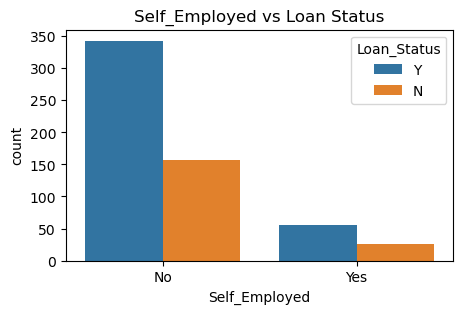

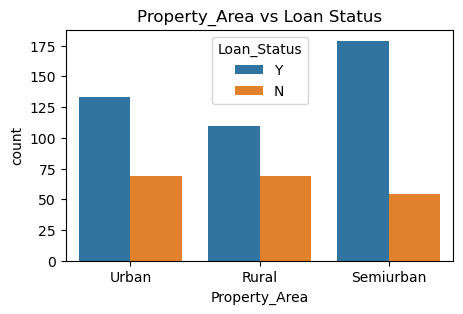

In [14]:
# Visualizing categorical variables
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, hue='Loan_Status', data=df)
    plt.title(f"{col} vs Loan Status")
    plt.show()

In [16]:
# Handle Missing Values
num_imputer = SimpleImputer(strategy='mean')  # For numerical columns
cat_imputer = SimpleImputer(strategy='most_frequent')  # For categorical columns

df[['LoanAmount', 'Loan_Amount_Term', 'Credit_History']] = num_imputer.fit_transform(df[['LoanAmount', 'Loan_Amount_Term', 'Credit_History']])
df[['Gender', 'Married', 'Dependents', 'Self_Employed']] = cat_imputer.fit_transform(df[['Gender', 'Married', 'Dependents', 'Self_Employed']])


In [18]:
# Encode categorical features
df.replace({"Loan_Status": {'N': 0, 'Y': 1}}, inplace=True)
df.replace({"Married": {'No': 0, 'Yes': 1}, "Gender": {'Female': 0, 'Male': 1},
            "Self_Employed": {'No': 0, 'Yes': 1}, "Property_Area": {'Rural': 0, 'Semiurban': 1, 'Urban': 2},
            "Education": {'Not Graduate': 0, 'Graduate': 1}}, inplace=True)
df.replace({'Dependents': {'3+': 4}}, inplace=True)

C:\Users\madur\AppData\Local\Temp\ipykernel_4288\3467234267.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Loan_Status": {'N': 0, 'Y': 1}}, inplace=True)
C:\Users\madur\AppData\Local\Temp\ipykernel_4288\3467234267.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Married": {'No': 0, 'Yes': 1}, "Gender": {'Female': 0, 'Male': 1},


In [20]:
# Separate features and target
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
Y = df['Loan_Status']

In [22]:
# Feature Selection
selector = SelectKBest(score_func=f_classif, k=8)
X_selected = selector.fit_transform(X, Y)
selected_features = np.array(X.columns)[selector.get_support()]
X = X[selected_features]

In [24]:
# Identify numerical columns dynamically
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

In [26]:
# Standardization
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [28]:
# Bias Mitigation - Handle Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

In [30]:
# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, stratify=Y_resampled, random_state=42)

In [32]:
# Hyperparameter Tuning Function
def tune_and_evaluate(model, param_grid, name):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_
    print(f"Best {name} Parameters: {grid_search.best_params_}")
    
    Y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"{name} Tuned Accuracy: {accuracy}")
    
    joblib.dump(best_model, f'loan_status_predict_{name.lower().replace(" ", "_")}')

In [34]:
# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}
tune_and_evaluate(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")

Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Tuned Accuracy: 0.8284023668639053


In [36]:
# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
tune_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, "XGBoost")

Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Tuned Accuracy: 0.7751479289940828


G:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Load Best Models and Print Accuracy
best_rf = joblib.load('loan_status_predict_random_forest')
best_xgb = joblib.load('loan_status_predict')

In [40]:
Y_pred_rf = best_rf.predict(X_test)
Y_pred_xgb = best_xgb.predict(X_test)

In [42]:
print(f"Final Tuned Random Forest Accuracy: {accuracy_score(Y_test, Y_pred_rf)}")
print(f"Final Tuned XGBoost Accuracy: {accuracy_score(Y_test, Y_pred_xgb)}")

Final Tuned Random Forest Accuracy: 0.8284023668639053
Final Tuned XGBoost Accuracy: 0.7751479289940828
